In [5]:
!pip3 install pymongo
!pip3 install statsmodels
!pip3 install seaborn
!pip3 install tabulate

In [54]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import pymongo
from pymongo import MongoClient
import warnings
import os
import plotly.express as px
from tabulate import tabulate
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [8]:
#Dataset Overview

In [9]:
# CSV file path
csv_file = "weather.csv"
# Read CSV file into pandas DataFrame
df = pd.read_csv(csv_file)
print(df)

             time  tavg  tmin  tmax  prcp
0      01-01-1990  22.9  19.1  28.4   NaN
1      02-01-1990  21.7   NaN  26.5   0.0
2      03-01-1990  21.0  16.4  26.5   0.0
3      04-01-1990  20.8   NaN  27.4   0.0
4      05-01-1990  20.4  14.2  26.1   0.0
...           ...   ...   ...   ...   ...
11889  21-07-2022  23.7  20.5  30.8  82.5
11890  22-07-2022  23.2  21.1  27.9   0.0
11891  23-07-2022  23.1  20.9  26.7   0.0
11892  24-07-2022  22.8  20.0  26.7   0.3
11893  25-07-2022  24.1  20.2  28.5   0.5

[11894 rows x 5 columns]


In [10]:
# Convert dataframe to dictionary format to insert into MongoDB
data = df.to_dict(orient="records")
# MongoDB URI, database, and collection names
mongo_uri = "mongodb://localhost:27017/"
database_nm = "mydatabase"
collection_nm = "mycollection"
# Create a MongoDB client
client = MongoClient(mongo_uri)
# Connect to the database and collection
db = client[database_nm]
collection = db[collection_nm]
# Insert CSV data into MongoDB
collection.insert_many(data)
print("CSV data successfully imported to MongoDB!")

CSV data successfully imported to MongoDB!


In [11]:
# Connect to MongoDB
client = pymongo.MongoClient(mongo_uri)
db = client[database_nm]
collection = db[collection_nm]
# Retrieve data from MongoDB (excluding the _id field)
data = list(collection.find({}, {"_id": 0}))
# Load data into pandas DataFrame
df = pd.DataFrame(data)
# Display basic info about the dataframe(50 entires)
print(df.info())
print(df.head(50))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35682 entries, 0 to 35681
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    35682 non-null  object 
 1   tavg    35472 non-null  float64
 2   tmin    31515 non-null  float64
 3   tmax    33795 non-null  float64
 4   prcp    21822 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.4+ MB
None
          time  tavg  tmin  tmax  prcp
0   01-01-1990  22.9  19.1  28.4   NaN
1   02-01-1990  21.7   NaN  26.5   0.0
2   03-01-1990  21.0  16.4  26.5   0.0
3   04-01-1990  20.8   NaN  27.4   0.0
4   05-01-1990  20.4  14.2  26.1   0.0
5   06-01-1990  20.4  17.1  24.2   NaN
6   07-01-1990  18.8   NaN  20.5   NaN
7   08-01-1990  20.0  16.6  25.1   0.0
8   09-01-1990  21.0  15.5   NaN   0.0
9   10-01-1990  21.2  15.0  27.7   0.0
10  11-01-1990  21.8  16.0  28.5   0.0
11  12-01-1990  21.1  13.2   NaN   0.0
12  13-01-1990  18.8  11.2  27.2   0.0
13  14-01-1990  19.8  11.5  29

In [12]:
# Display basic info in MongoDB(10 entires)
result=collection.find().limit(10)
for document in result:
    print(document)

{'_id': ObjectId('67f60de3eeefa413719ae52d'), 'time': '01-01-1990', 'tavg': 22.9, 'tmin': 19.1, 'tmax': 28.4, 'prcp': nan}
{'_id': ObjectId('67f60de3eeefa413719ae52e'), 'time': '02-01-1990', 'tavg': 21.7, 'tmin': nan, 'tmax': 26.5, 'prcp': 0.0}
{'_id': ObjectId('67f60de3eeefa413719ae52f'), 'time': '03-01-1990', 'tavg': 21.0, 'tmin': 16.4, 'tmax': 26.5, 'prcp': 0.0}
{'_id': ObjectId('67f60de3eeefa413719ae530'), 'time': '04-01-1990', 'tavg': 20.8, 'tmin': nan, 'tmax': 27.4, 'prcp': 0.0}
{'_id': ObjectId('67f60de3eeefa413719ae531'), 'time': '05-01-1990', 'tavg': 20.4, 'tmin': 14.2, 'tmax': 26.1, 'prcp': 0.0}
{'_id': ObjectId('67f60de3eeefa413719ae532'), 'time': '06-01-1990', 'tavg': 20.4, 'tmin': 17.1, 'tmax': 24.2, 'prcp': nan}
{'_id': ObjectId('67f60de3eeefa413719ae533'), 'time': '07-01-1990', 'tavg': 18.8, 'tmin': nan, 'tmax': 20.5, 'prcp': nan}
{'_id': ObjectId('67f60de3eeefa413719ae534'), 'time': '08-01-1990', 'tavg': 20.0, 'tmin': 16.6, 'tmax': 25.1, 'prcp': 0.0}
{'_id': ObjectId('6

In [13]:
#Data Preprocessing

In [14]:
# Convert 'time' column to datetime format
df['time'] = pd.to_datetime(df['time'], format='%d-%m-%Y', errors='coerce')
# Set the 'time' column as the index
df.set_index('time', inplace=True)

In [15]:
# Check for missing values
missing_pctg = round((df.isna().sum().sum() / df.size) * 100, 2)
print(f"{missing_pctg}% of the data contains NaN values")

14.1% of the data contains NaN values


In [16]:
# Drop rows with all missing values
df = df.dropna(how='all')
# Interpolate missing values based on time
df = df.interpolate(method='time')
# Fill any remaining NaN values with 0
df.fillna(0, inplace=True)
print(df.isna().sum())

tavg    0
tmin    0
tmax    0
prcp    0
dtype: int64


In [17]:
#Exploratory Data Analysis (EDA) and Feature Engineering

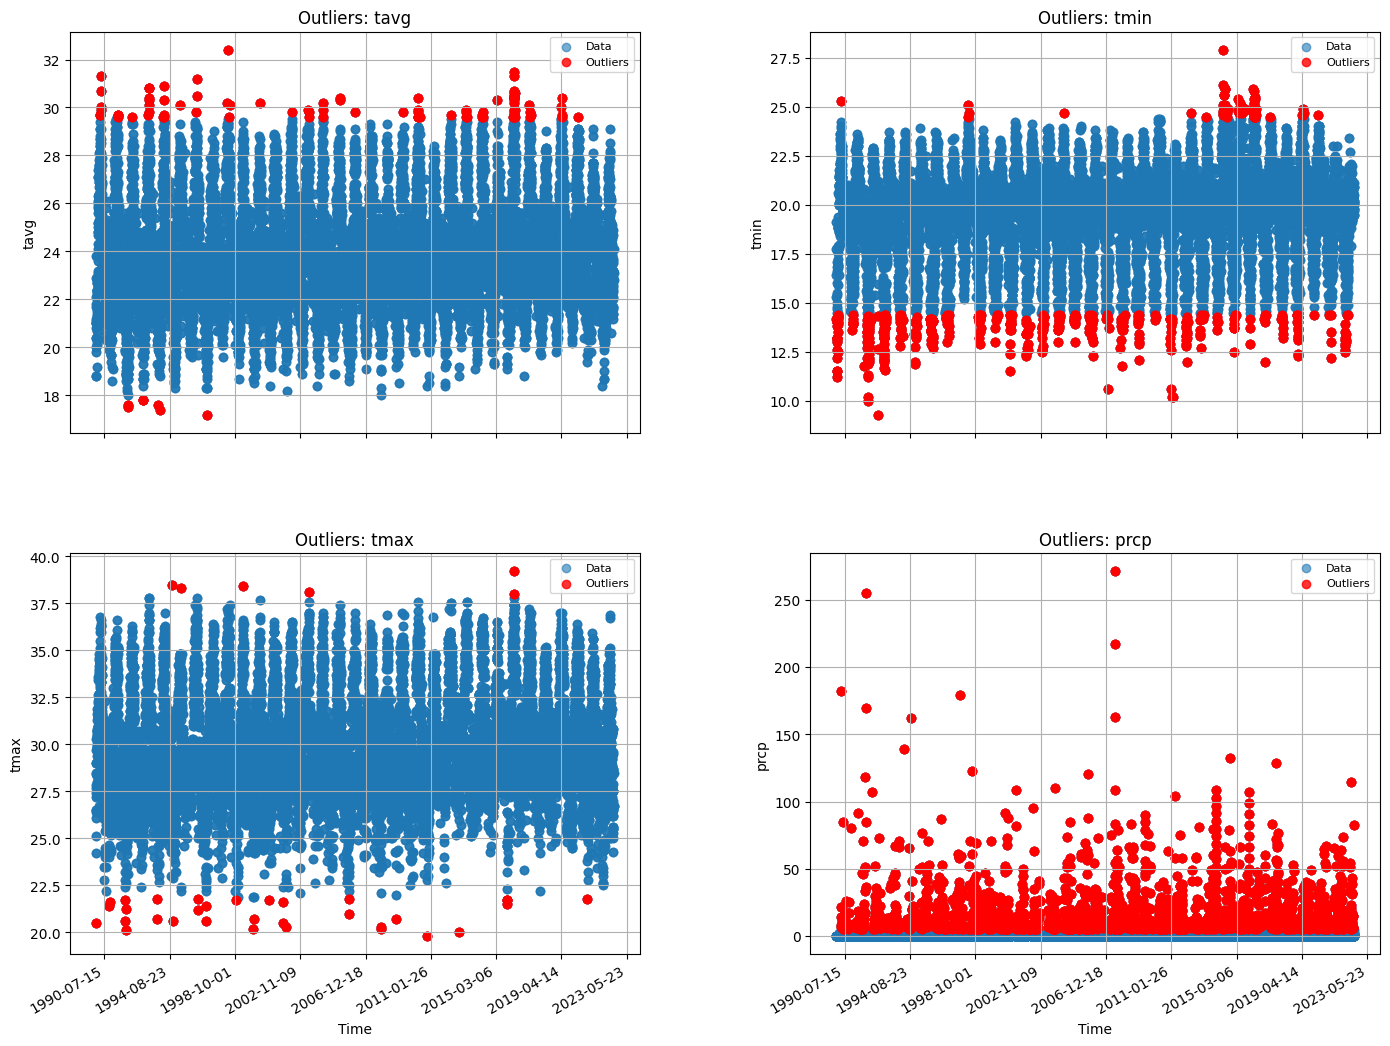

In [18]:
# Function to plot outliers using IQR
def plot_weather_outliers_iqr(data):
    # Select relevant columns (tavg, tmin, tmax, prcp)
    numeric_columns = ['tavg', 'tmin', 'tmax', 'prcp']  # Only include temperature and precipitation columns
    threshold = 1.5  # IQR threshold for outlier detection
    
    # Determine the number of rows and columns for subplots based on the number of numeric columns
    n_cols = 2  # 2 columns per row
    n_rows = -(-len(numeric_columns) // n_cols)  # Calculate number of rows needed
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, n_rows * 6), squeeze=False)
    axes = axes.flatten()  # Flatten the axes to make indexing easier
    
    for idx, column in enumerate(numeric_columns):
        # Calculate the IQR for each column
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR

        # Identify outliers
        outliers = (data[column] < lower_bound) | (data[column] > upper_bound)

        # Plot data points and outliers
        axes[idx].scatter(data.index, data[column], label='Data', alpha=0.6)
        axes[idx].scatter(data.index[outliers], data[column][outliers], color='red', label='Outliers', alpha=0.8)
        axes[idx].set_title(f"Outliers: {column}", fontsize=12)
        axes[idx].set_xlabel("Time", fontsize=10)
        axes[idx].set_ylabel(column, fontsize=10)
        axes[idx].legend(fontsize=8)
        axes[idx].grid(True)

        # Rotate x-axis labels to avoid overlapping
        for label in axes[idx].get_xticklabels():
            label.set_rotation(45)  # Rotate the x-axis labels
            label.set_horizontalalignment('right')  # Align labels to the right

        # Use MaxNLocator to adjust the x-axis labels
        axes[idx].xaxis.set_major_locator(MaxNLocator(integer=True, prune='both'))

    # Turn off empty subplots
    for ax in axes[len(numeric_columns):]:
        ax.axis('off')
    
    # Adjust layout and ensure x-labels are properly spaced
    plt.tight_layout()

    # Automatically format the x-axis labels (dates) to prevent overlap
    fig.autofmt_xdate()  # Auto format date labels to improve spacing
    
    # Add extra spacing between subplots if needed
    plt.subplots_adjust(hspace=0.3, wspace=0.3)
    
    plt.show()

# Call the function to plot outliers
plot_weather_outliers_iqr(df)

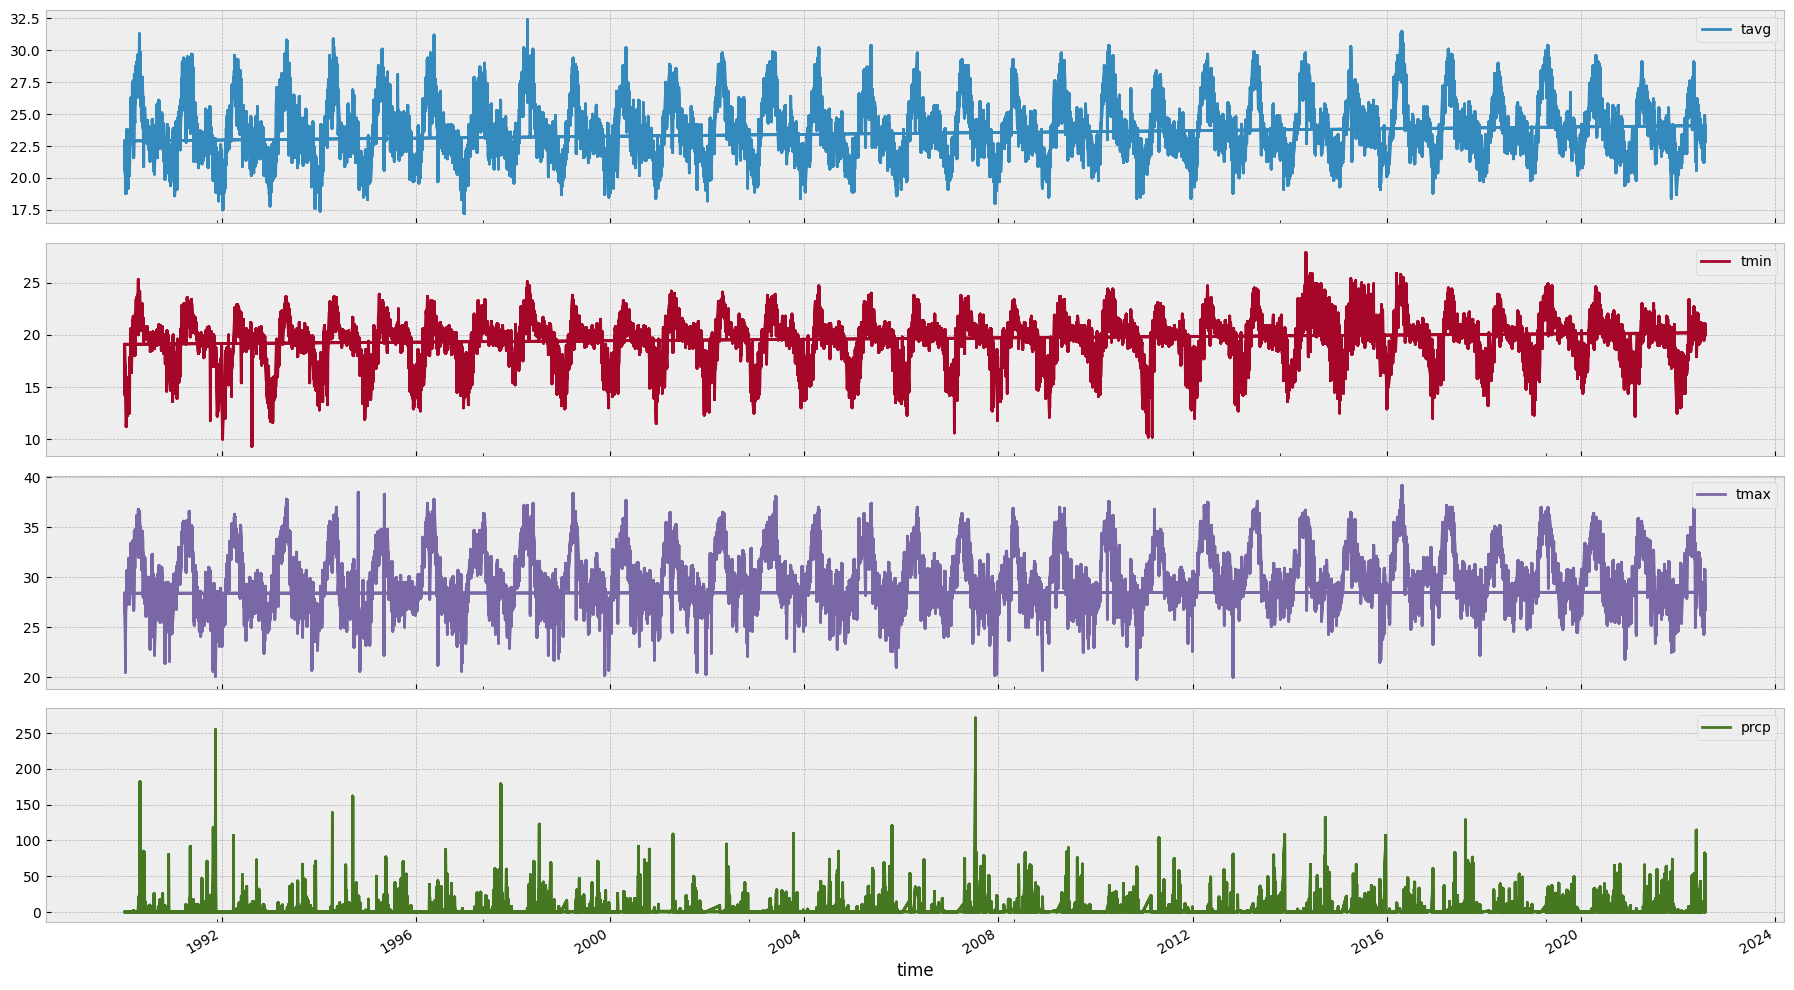

In [19]:
# Plot the specified columns from the DataFrame as separate subplots
plt.style.use('bmh')
required_columns = ['tavg', 'tmin', 'tmax', 'prcp']
df[required_columns].plot(subplots=True, figsize=(18, 10))
plt.tight_layout()
plt.show()

In [20]:
# Group by year and calculate the mean for temperature and precipitation
df['year'] = df.index.year
df_year = df.groupby('year').mean()

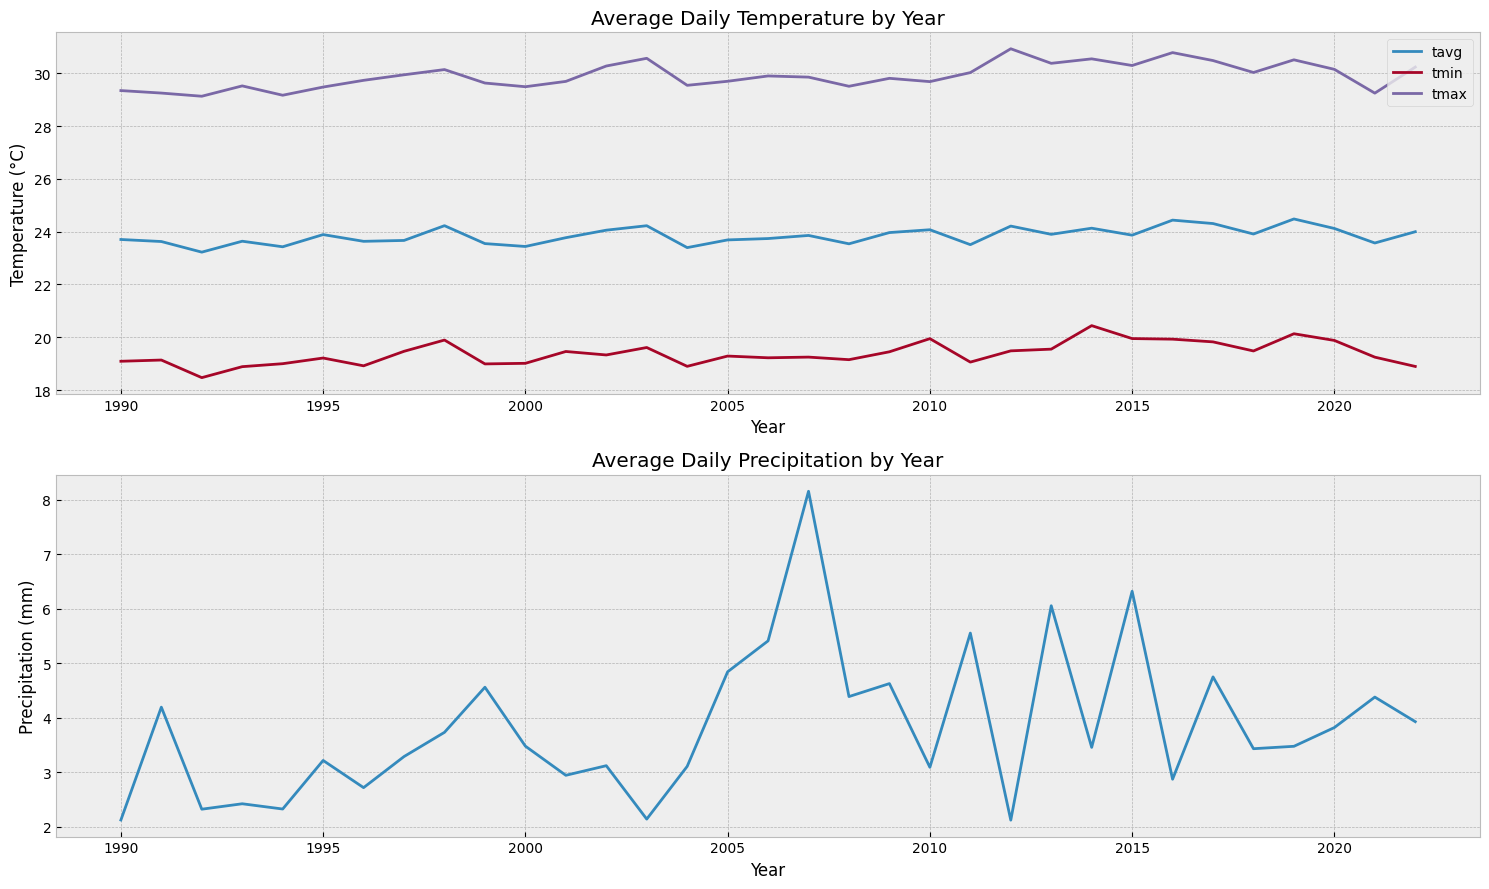

In [21]:
# Plotting temperature and precipitation over the years
f, axes = plt.subplots(nrows=2, figsize=(15, 9))

# Plot average temperature
ax = df_year[['tavg', 'tmin', 'tmax']].plot(ax=axes[0])
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Year')
ax.set_title('Average Daily Temperature by Year')
ax.grid(True)  # Add gridlines for temperature plot

# Plot average precipitation
ax = df_year['prcp'].plot(ax=axes[1])
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Year')
ax.set_title('Average Daily Precipitation by Year')
ax.grid(True)  # Add gridlines for precipitation plot

plt.tight_layout()
plt.show()

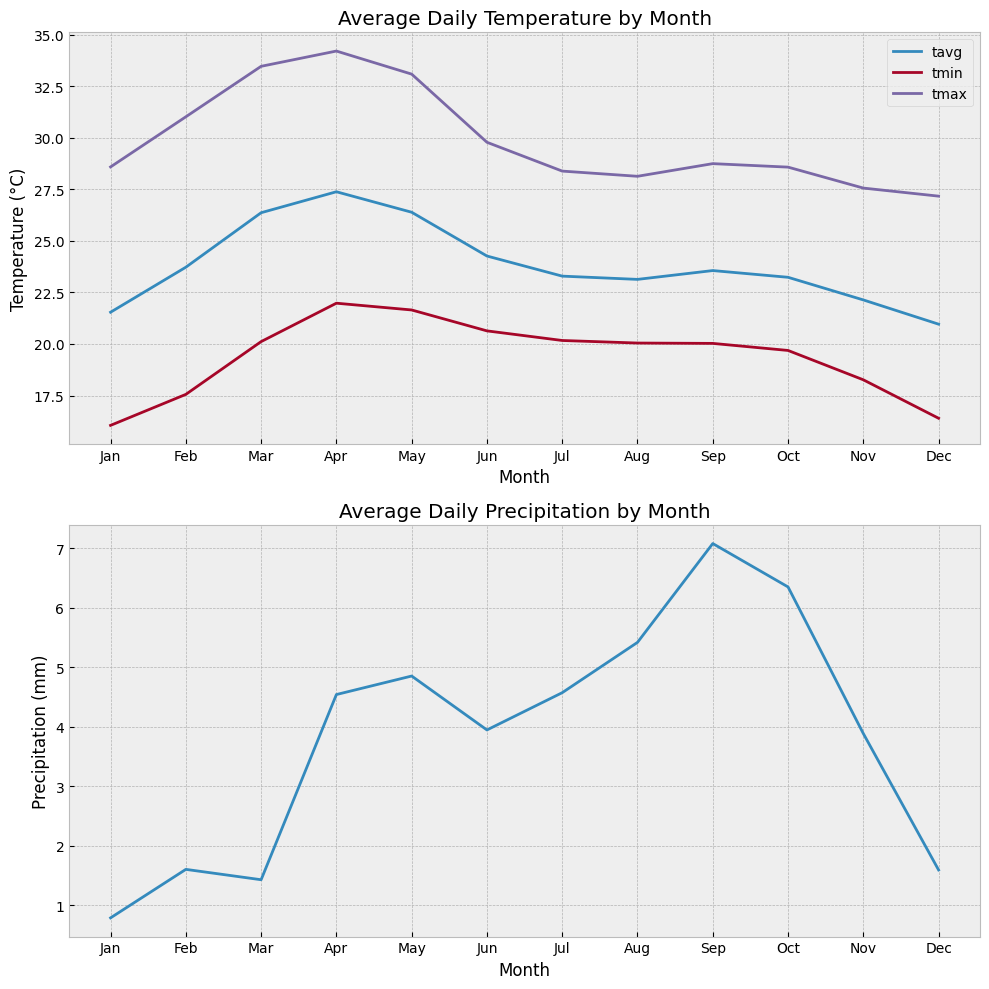

In [22]:
# Add a 'month' column to group by month
df['month'] = df.index.month

# Group by month and calculate the mean for temperature and precipitation
data_month = df.groupby('month', as_index=False)[['tavg', 'tmin', 'tmax', 'prcp']].mean()

# Plotting the data
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
f, axes = plt.subplots(nrows=2, figsize=(10, 10))

# Temperature plot
ax = data_month[['tavg', 'tmin', 'tmax']].plot(ax=axes[0])
ax.set_ylabel('Temperature (°C)')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(0, 12))  # Ensure the x-ticks are aligned with months
ax.set_xticklabels(months)  # Replace numbers with month names
ax.set_title('Average Daily Temperature by Month')
ax.grid(True)  # Add gridlines for temperature plot

# Precipitation plot
ax = data_month['prcp'].plot(ax=axes[1])
ax.set_ylabel('Precipitation (mm)')
ax.set_xlabel('Month')
ax.set_xticks(np.arange(0, 12))  # Ensure the x-ticks are aligned with months
ax.set_xticklabels(months)  # Replace numbers with month names
ax.set_title('Average Daily Precipitation by Month')
ax.grid(True)  # Add gridlines for precipitation plot

plt.tight_layout()
plt.show()

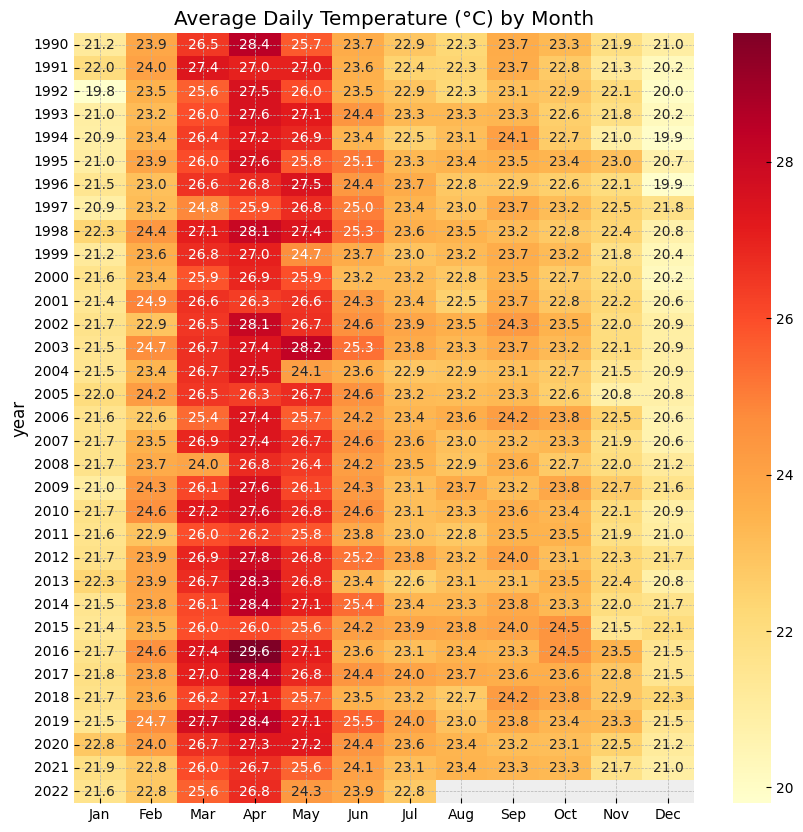

In [23]:
# Group by year and month, calculate the mean for temperature and precipitation
month_df = df.groupby(['year', 'month'], as_index=False)[['tavg', 'prcp']].mean()
# Pivot data for heatmap visualization
temperature_data = month_df.pivot(index='year', columns='month', values='tavg')
temperature_data.columns = months
# Plot heatmap for average temperature
plt.subplots(figsize=(10, 10))
sns.heatmap(temperature_data, cmap='YlOrRd', annot=True, fmt='.1f')
plt.title('Average Daily Temperature (°C) by Month')
plt.yticks(rotation=0)
plt.show()

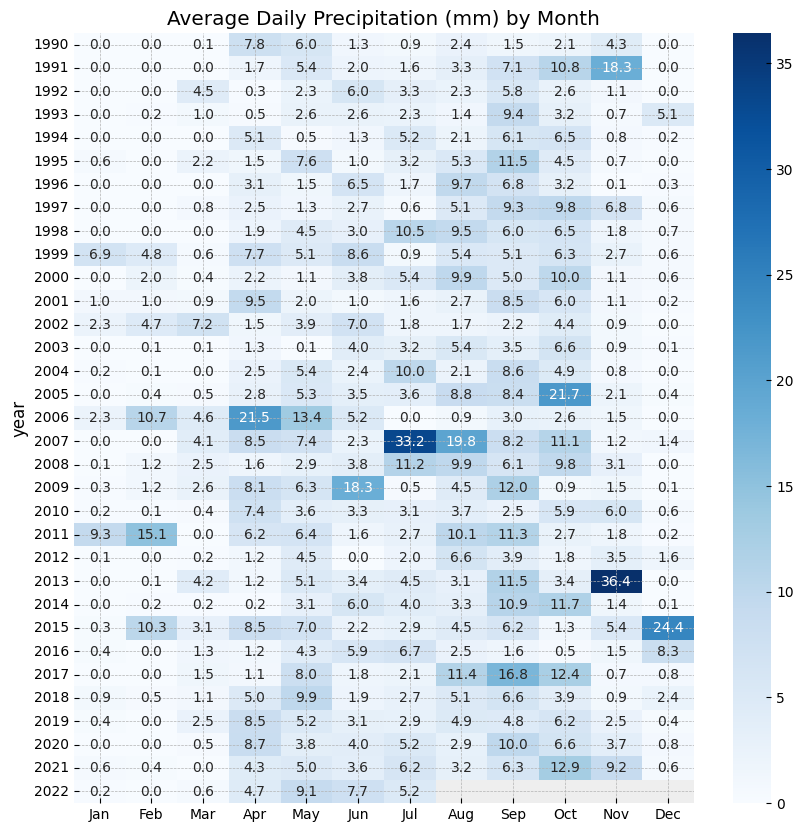

In [24]:
# Pivot data for precipitation
precipitation_data = month_df.pivot(index='year', columns='month', values='prcp')
precipitation_data.columns = months
# Plot heatmap for average precipitation
plt.subplots(figsize=(10, 10))
sns.heatmap(precipitation_data, cmap='Blues', annot=True, fmt='.1f')
plt.title('Average Daily Precipitation (mm) by Month')
plt.yticks(rotation=0)
plt.show()

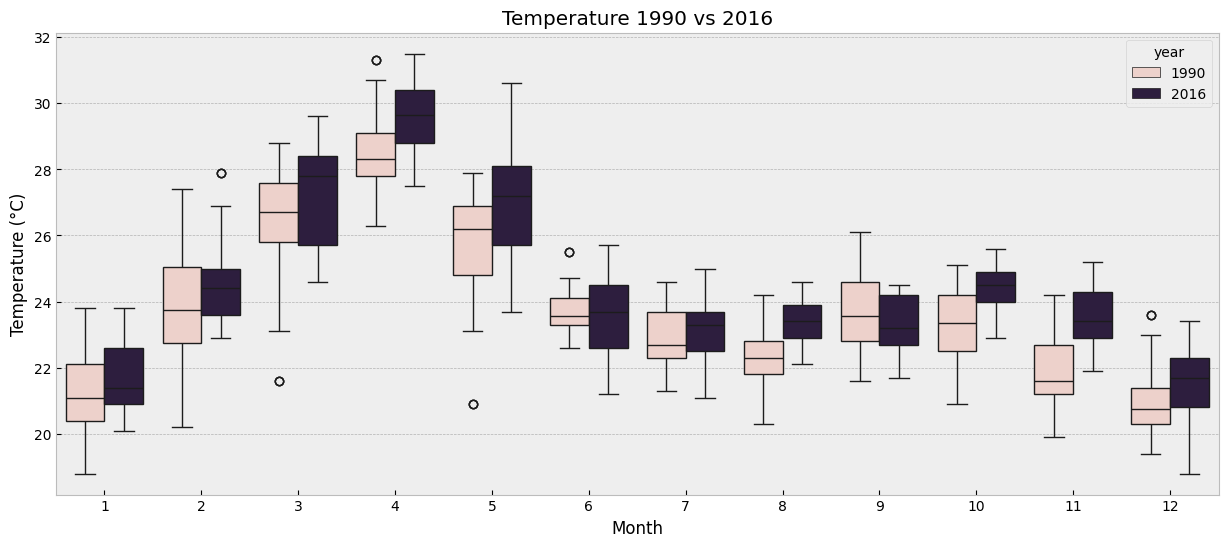

In [25]:
# Filter data for specific years (e.g., 1990 and 2016)
data_years = df[df['year'].isin([1990, 2016])]
# Boxplot for temperature comparison (1990 vs 2016)
plt.subplots(figsize=(15, 6))
sns.boxplot(x='month', y='tavg', hue='year', data=data_years, saturation=1)
plt.xlabel('Month')
plt.ylabel('Temperature (°C)')
plt.title('Temperature 1990 vs 2016')
plt.show()

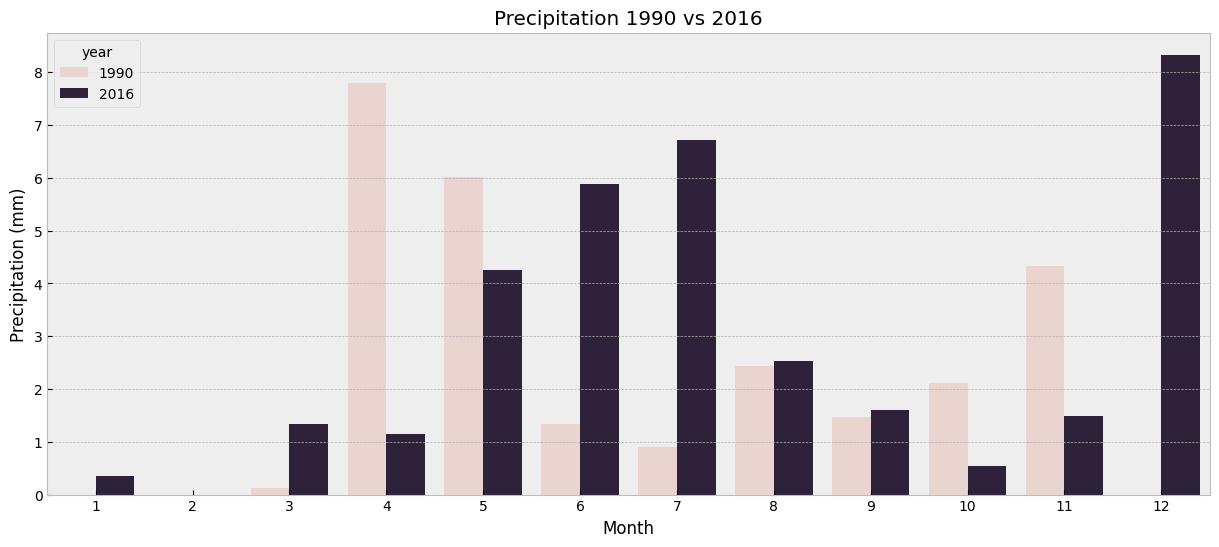

In [29]:
# Barplot for precipitation comparison (1990 vs 2016)
plt.subplots(figsize=(15, 6))
sns.barplot(x='month', y='prcp', hue='year', data=data_years, errorbar=None)
plt.xlabel('Month')
plt.ylabel('Precipitation (mm)')
plt.title('Precipitation 1990 vs 2016')
plt.show()

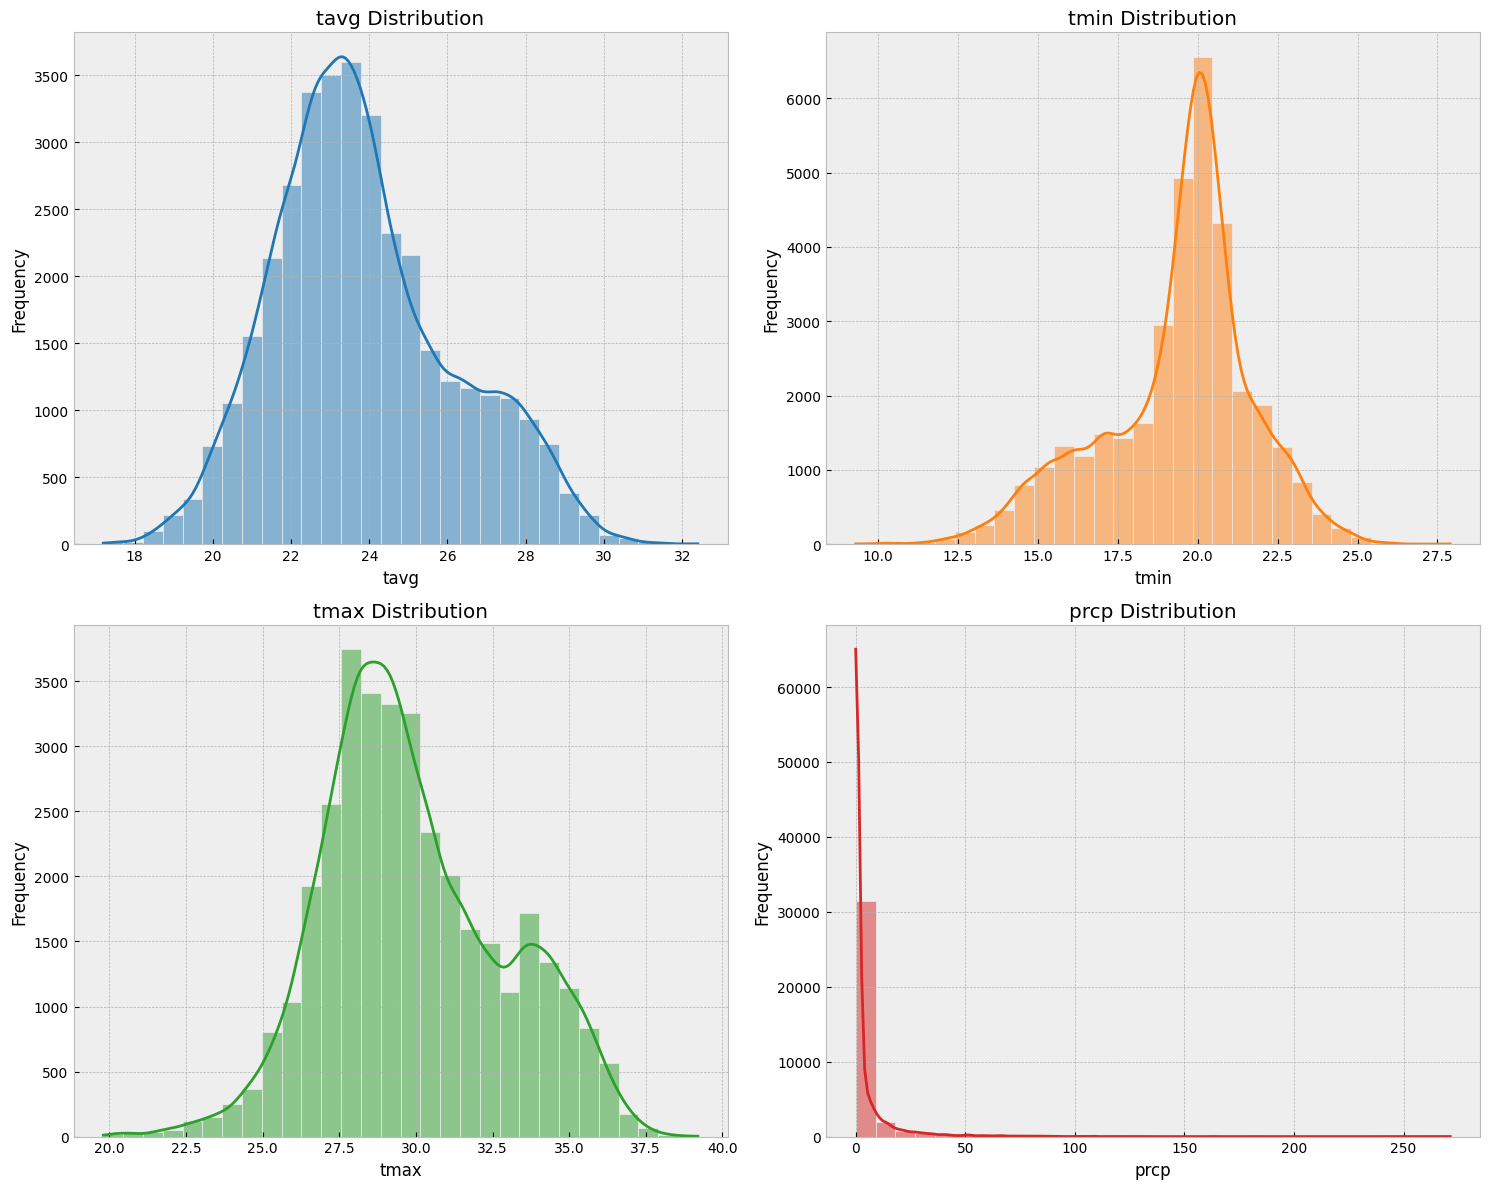

In [30]:
# Define the colors for each weather metric
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Colors for each weather variable

# Define the columns of interest for weather data
weather_columns = ['tavg', 'tmin', 'tmax', 'prcp']

# Create a subplot grid to display histograms and KDE for each weather variable
plt.figure(figsize=(15, 12))

# Iterate through each weather column to create histograms and KDE plots
for idx, column in enumerate(weather_columns):
    plt.subplot(2, 2, idx + 1)  # Arrange 2x2 subplots
    sns.histplot(df[column], bins=30, kde=True, color=colors[idx])  # Plot histogram and KDE
    plt.title(f'{column} Distribution')  # Set title for the subplot
    plt.xlabel(column)  # Set x-axis label
    plt.ylabel('Frequency')  # Set y-axis label

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [31]:
#Feature Engineering

In [32]:
# Create seasonal features
# Map each month to its meteorological season
season_mapping = {
    1: 'Winter', 2: 'Winter', 3: 'Spring', 4: 'Spring', 
    5: 'Spring', 6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall', 12: 'Winter'
}
df['season'] = df['month'].map(season_mapping)

# Check the distribution of seasons
season_counts = df['season'].value_counts()
print(season_counts)

season
Spring    9030
Summer    8961
Winter    8802
Fall      8679
Name: count, dtype: int64


In [33]:
# Create temperature range feature (daily temperature variation)
df['temp_range'] = df['tmax'] - df['tmin']

# Create binned versions of numeric features
df['temp_category'] = pd.cut(df['tavg'], 
                             bins=[-100, 0, 10, 20, 100], 
                             labels=['Freezing', 'Cold', 'Mild', 'Hot'])

df['precipitation_category'] = pd.cut(df['prcp'], 
                                      bins=[-1, 0, 5, 15, 1000], 
                                      labels=['None', 'Light', 'Moderate', 'Heavy'])

# Display the distribution of these categorical features
print(df['temp_category'].value_counts())
print(df['precipitation_category'].value_counts())

temp_category
Hot         34404
Mild         1068
Cold            0
Freezing        0
Name: count, dtype: int64
precipitation_category
None        18882
Light       10506
Moderate     3636
Heavy        2448
Name: count, dtype: int64


In [34]:
# Create temperature range feature (daily temperature variation)
df['temp_range'] = df['tmax'] - df['tmin']

# Create binned versions of numeric features
df['temp_category'] = pd.cut(df['tavg'], 
                             bins=[-100, 0, 10, 20, 100], 
                             labels=['Freezing', 'Cold', 'Mild', 'Hot'])

df['precipitation_category'] = pd.cut(df['prcp'], 
                                      bins=[-1, 0, 5, 15, 1000], 
                                      labels=['None', 'Light', 'Moderate', 'Heavy'])

# Display the distribution of these categorical features
print(df['temp_category'].value_counts())
print(df['precipitation_category'].value_counts())

temp_category
Hot         34404
Mild         1068
Cold            0
Freezing        0
Name: count, dtype: int64
precipitation_category
None        18882
Light       10506
Moderate     3636
Heavy        2448
Name: count, dtype: int64


In [67]:
# Create lag features for time series analysis
# Previous day's temperature and precipitation
df['tavg_lag1'] = df['tavg'].shift(1)
df['prcp_lag1'] = df['prcp'].shift(1)

# 7-day moving averages (weekly trends)
df['tavg_7day_avg'] = df['tavg'].rolling(window=7).mean()
df['prcp_7day_avg'] = df['prcp'].rolling(window=7).mean()

# 30-day moving averages (monthly trends)
df['tavg_30day_avg'] = df['tavg'].rolling(window=30).mean()
df['prcp_30day_avg'] = df['prcp'].rolling(window=30).mean()

# Fill NaN values created by shifts and rolling windows
lag_columns = ['tavg_lag1', 'prcp_lag1', 'tavg_7day_avg', 'prcp_7day_avg', 'tavg_30day_avg', 'prcp_30day_avg']
df[lag_columns] = df[lag_columns].bfill()

# Display the first few rows with the new features
print(df[['tavg', 'tavg_lag1', 'tavg_7day_avg', 'tavg_30day_avg']].head(10))

            tavg  tavg_lag1  tavg_7day_avg  tavg_30day_avg
time                                                      
1990-01-01  22.9       22.9      20.857143       21.153333
1990-01-02  21.7       22.9      20.857143       21.153333
1990-01-03  21.0       21.7      20.857143       21.153333
1990-01-04  20.8       21.0      20.857143       21.153333
1990-01-05  20.4       20.8      20.857143       21.153333
1990-01-06  20.4       20.4      20.857143       21.153333
1990-01-07  18.8       20.4      20.857143       21.153333
1990-01-08  20.0       18.8      20.442857       21.153333
1990-01-09  21.0       20.0      20.342857       21.153333
1990-01-10  21.2       21.0      20.371429       21.153333


In [36]:
# Create day of year feature (1-366)
df['day_of_year'] = df.index.dayofyear

# Create cyclical features for month and day of year 
# This helps the model understand the cyclical nature of time
df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year']/366)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year']/366)

# Display the first few rows with cyclical features
print(df[['month', 'month_sin', 'month_cos', 'day_of_year', 'day_sin', 'day_cos']].head())

            month  month_sin  month_cos  day_of_year   day_sin   day_cos
time                                                                    
1990-01-01      1        0.5   0.866025            1  0.017166  0.999853
1990-01-02      1        0.5   0.866025            2  0.034328  0.999411
1990-01-03      1        0.5   0.866025            3  0.051479  0.998674
1990-01-04      1        0.5   0.866025            4  0.068615  0.997643
1990-01-05      1        0.5   0.866025            5  0.085731  0.996318


In [37]:
# Create interaction features
df['temp_prcp_interaction'] = df['tavg'] * df['prcp']

# Create polynomial features for temperature
df['tavg_squared'] = df['tavg'] ** 2

# Create features for extreme weather events
df['extreme_heat'] = (df['tmax'] > df['tmax'].quantile(0.95)).astype(int)
df['extreme_cold'] = (df['tmin'] < df['tmin'].quantile(0.05)).astype(int)
df['heavy_rain'] = (df['prcp'] > df['prcp'].quantile(0.95)).astype(int)

# Display counts of extreme weather days
print(f"Extreme heat days: {df['extreme_heat'].sum()}")
print(f"Extreme cold days: {df['extreme_cold'].sum()}")
print(f"Heavy rain days: {df['heavy_rain'].sum()}")

Extreme heat days: 1755
Extreme cold days: 1662
Heavy rain days: 1773


In [66]:
# Create features for consecutive days using rolling window operations
# For rain days
rain_threshold = 0.1  # Example threshold for rain (e.g., 0.1 inches of precipitation)
df['is_rainy'] = (df['prcp'] > rain_threshold).astype(int)
df['rain_spell_id'] = (df['is_rainy'] != df['is_rainy'].shift(1)).cumsum()
df['consec_rain_days'] = df.groupby(['rain_spell_id', 'is_rainy'])['is_rainy'].cumcount() + 1
df.loc[df['is_rainy'] == 0, 'consec_rain_days'] = 0

# For hot days
hot_threshold = 30    # Example threshold for hot days (e.g., 30°C or 86°F)
df['is_hot'] = (df['tavg'] > hot_threshold).astype(int) 
df['hot_spell_id'] = (df['is_hot'] != df['is_hot'].shift(1)).cumsum()
df['consec_hot_days'] = df.groupby(['hot_spell_id', 'is_hot'])['is_hot'].cumcount() + 1
df.loc[df['is_hot'] == 0, 'consec_hot_days'] = 0

# Clean up intermediate columns
df = df.drop(['is_rainy', 'rain_spell_id', 'is_hot', 'hot_spell_id'], axis=1)

# Display maximum consecutive days
print(f"Maximum consecutive rainy days: {df['consec_rain_days'].max()}")
print(f"Maximum consecutive hot days: {df['consec_hot_days'].max()}")

Maximum consecutive rainy days: 105
Maximum consecutive hot days: 6


In [39]:
# Create features for deviation from seasonal norms
# First, calculate seasonal averages
seasonal_tavg = df.groupby(['month'])['tavg'].transform('mean')
seasonal_prcp = df.groupby(['month'])['prcp'].transform('mean')

# Calculate deviations
df['tavg_seasonal_dev'] = df['tavg'] - seasonal_tavg
df['prcp_seasonal_dev'] = df['prcp'] - seasonal_prcp

# Display summary of seasonal deviations
print(df[['tavg_seasonal_dev', 'prcp_seasonal_dev']].describe())

       tavg_seasonal_dev  prcp_seasonal_dev
count       3.547200e+04       3.547200e+04
mean        4.935660e-16       8.332932e-17
std         1.298849e+00       1.152827e+01
min        -6.080263e+00      -7.077250e+00
25%        -8.324847e-01      -4.539424e+00
50%         1.101278e-02      -1.600885e+00
75%         8.410417e-01      -7.857170e-01
max         5.019737e+00       2.667294e+02


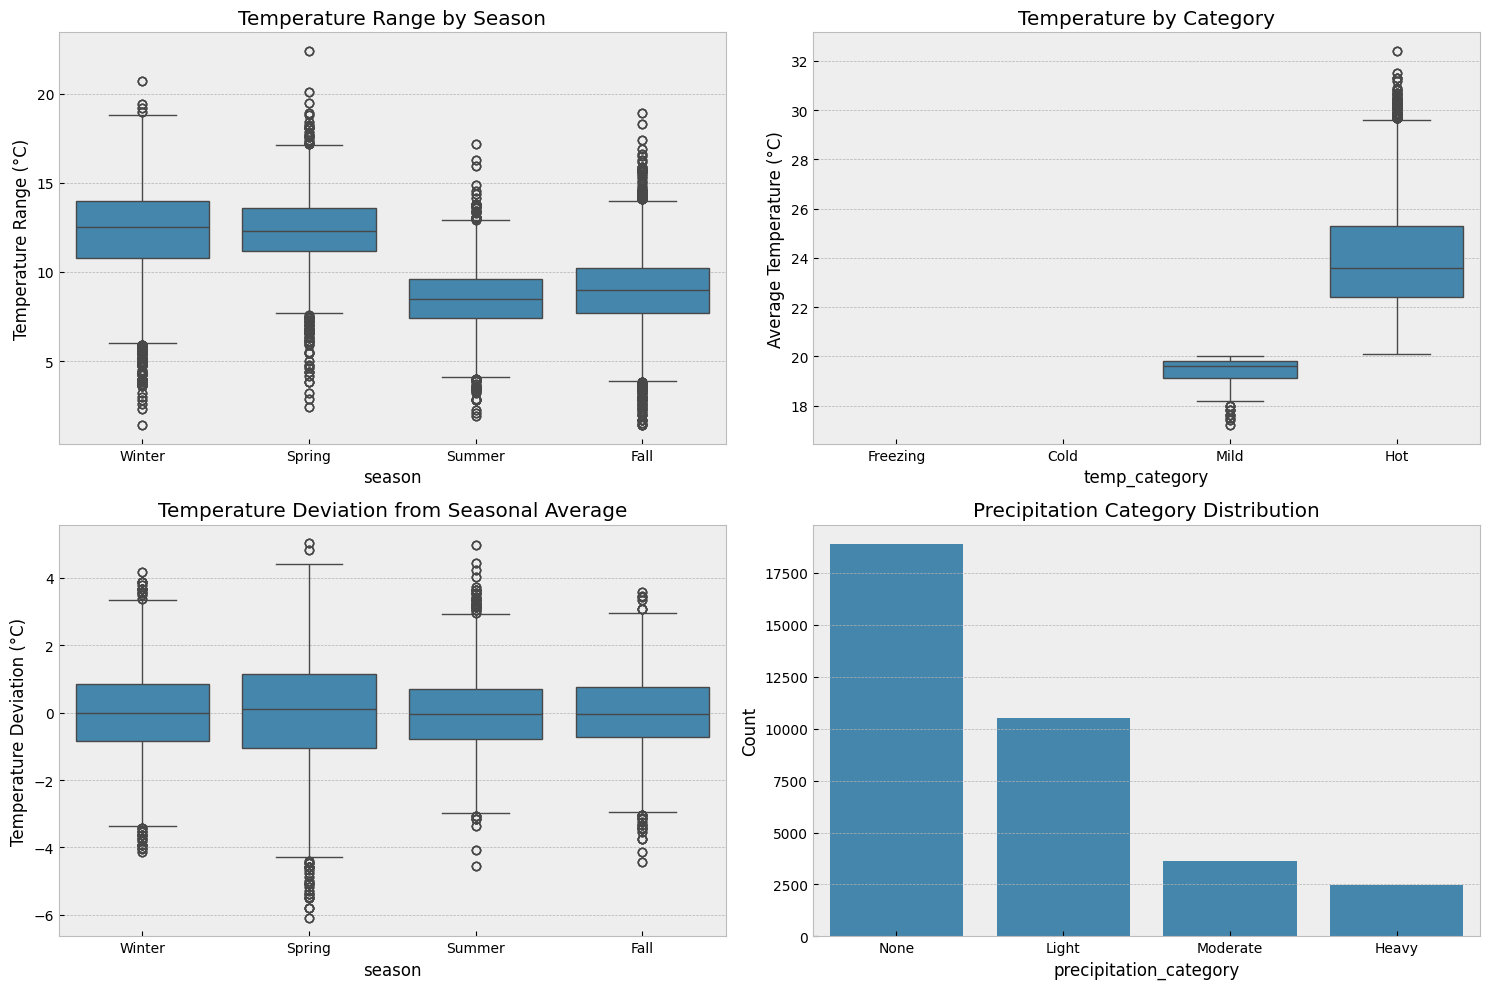

In [40]:
# Create a visualization of the new features
plt.figure(figsize=(15, 10))

# Plot 1: Temperature Range by Season
plt.subplot(2, 2, 1)
sns.boxplot(x='season', y='temp_range', data=df)
plt.title('Temperature Range by Season')
plt.ylabel('Temperature Range (°C)')

# Plot 2: Average Temperature vs. Temperature Category
plt.subplot(2, 2, 2)
sns.boxplot(x='temp_category', y='tavg', data=df)
plt.title('Temperature by Category')
plt.ylabel('Average Temperature (°C)')

# Plot 3: Seasonal Temperature Deviation
plt.subplot(2, 2, 3)
sns.boxplot(x='season', y='tavg_seasonal_dev', data=df)
plt.title('Temperature Deviation from Seasonal Average')
plt.ylabel('Temperature Deviation (°C)')

# Plot 4: Precipitation by Category
plt.subplot(2, 2, 4)
sns.countplot(x='precipitation_category', data=df)
plt.title('Precipitation Category Distribution')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

Available columns in dataframe:
['tavg', 'tmin', 'tmax', 'prcp', 'year', 'month', 'season', 'temp_range', 'temp_category', 'precipitation_category', 'tavg_lag1', 'prcp_lag1', 'tavg_7day_avg', 'prcp_7day_avg', 'tavg_30day_avg', 'prcp_30day_avg', 'day_of_year', 'month_sin', 'month_cos', 'day_sin', 'day_cos', 'temp_prcp_interaction', 'tavg_squared', 'extreme_heat', 'extreme_cold', 'heavy_rain', 'tavg_seasonal_dev', 'prcp_seasonal_dev', 'Cluster']


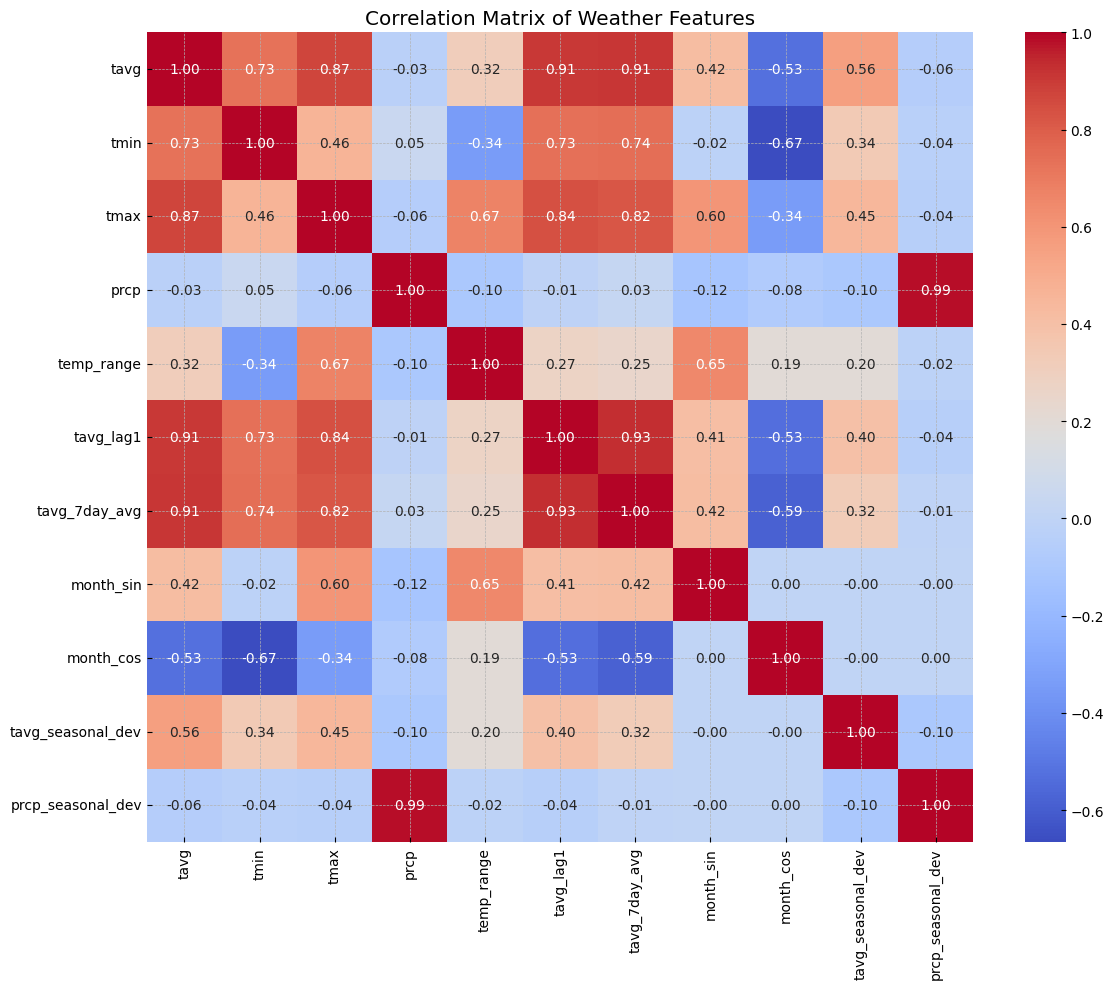

In [65]:
# Create a correlation matrix of new and original features
print("Available columns in dataframe:")
print(df.columns.tolist())
# Removing 'consec_rain_days' and 'consec_hot_days' which are missing
selected_features = ['tavg', 'tmin', 'tmax', 'prcp', 
                     'temp_range', 'tavg_lag1', 'tavg_7day_avg',
                     'month_sin', 'month_cos', 'tavg_seasonal_dev', 
                     'prcp_seasonal_dev']

# Calculate and plot correlation matrix
corr_matrix = df[selected_features].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Weather Features')
plt.tight_layout()
plt.show()

In [42]:
# Model Training

In [43]:
# Prepare the data for Random Forest Regression
# Use 'tmin', 'tmax', 'prcp' to predict 'tavg'
X = df[['tmin', 'tmax', 'prcp']]  # Features (independent variables)
y = df['tavg']  # Target variable (dependent variable)

# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation metrics
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 0.23
Mean Squared Error (MSE): 0.14
R² Score: 0.97


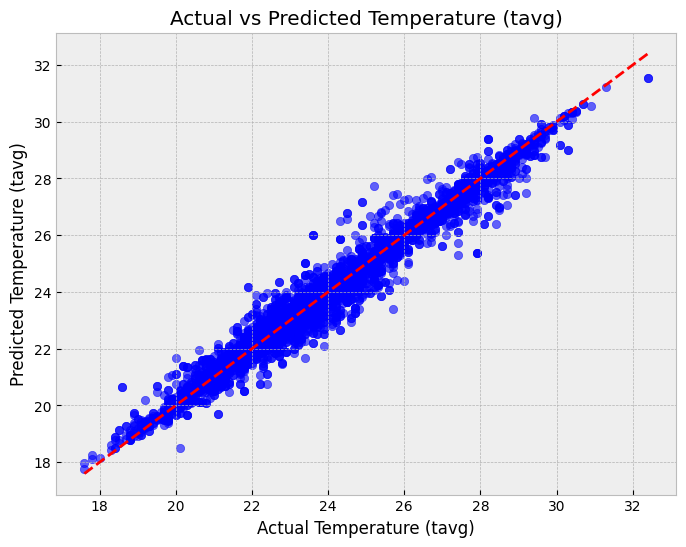

In [44]:
# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--')
plt.xlabel('Actual Temperature (tavg)')
plt.ylabel('Predicted Temperature (tavg)')
plt.title('Actual vs Predicted Temperature (tavg)')
plt.show()

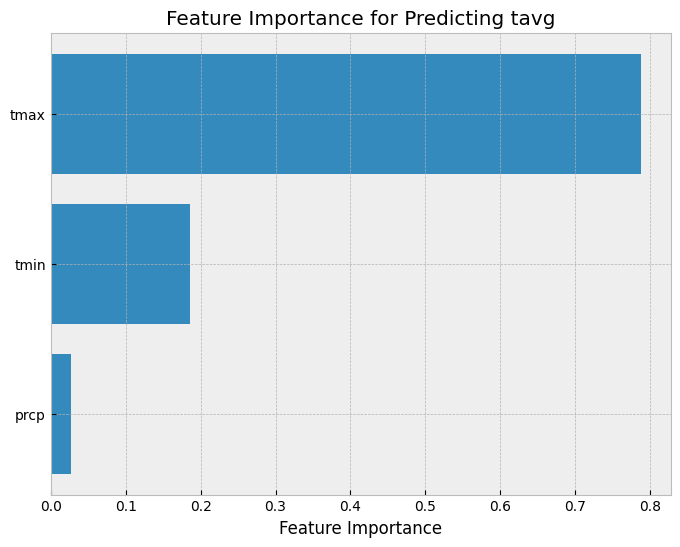

In [45]:
# Plot feature importances
features = ['tmin', 'tmax', 'prcp']
importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance for Predicting tavg')
plt.show()

In [46]:
# Additional imports for clustering
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Prepare the data for K-Means Clustering
# Using 'tmin', 'tmax', 'prcp' as features for clustering
X = df[['tmin', 'tmax', 'prcp']]  # Features (independent variables)

# Standardize the data using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define the number of clusters
n_clusters = 3  # You can change this number based on your analysis (using methods like Elbow or Silhouette)

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(X_scaled)

# Assign the cluster labels to the original dataframe
df['Cluster'] = kmeans.labels_

# Display the first few rows of the dataframe with cluster labels
print(df.head())

            tavg   tmin  tmax  prcp  year  month  season  temp_range  \
time                                                                   
1990-01-01  22.9  19.10  28.4   0.0  1990      1  Winter        9.30   
1990-01-02  21.7  17.75  26.5   0.0  1990      1  Winter        8.75   
1990-01-03  21.0  16.40  26.5   0.0  1990      1  Winter       10.10   
1990-01-04  20.8  15.30  27.4   0.0  1990      1  Winter       12.10   
1990-01-05  20.4  14.20  26.1   0.0  1990      1  Winter       11.90   

           temp_category precipitation_category  ...   day_sin   day_cos  \
time                                             ...                       
1990-01-01           Hot                   None  ...  0.017166  0.999853   
1990-01-02           Hot                   None  ...  0.034328  0.999411   
1990-01-03           Hot                   None  ...  0.051479  0.998674   
1990-01-04           Hot                   None  ...  0.068615  0.997643   
1990-01-05           Hot               

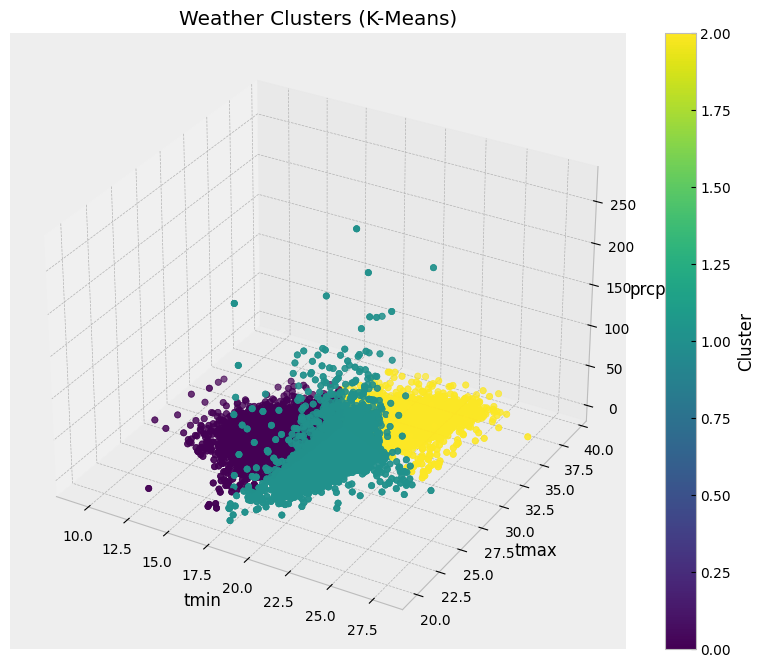

In [47]:
# Plot clusters in 3D (using tmin, tmax, prcp for the 3D space)
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot each cluster with a different color
scatter = ax.scatter(df['tmin'], df['tmax'], df['prcp'], c=df['Cluster'], cmap='viridis')
ax.set_xlabel('tmin')
ax.set_ylabel('tmax')
ax.set_zlabel('prcp')
ax.set_title('Weather Clusters (K-Means)')

# Add a color bar for the clusters
plt.colorbar(scatter, label='Cluster')
plt.show()

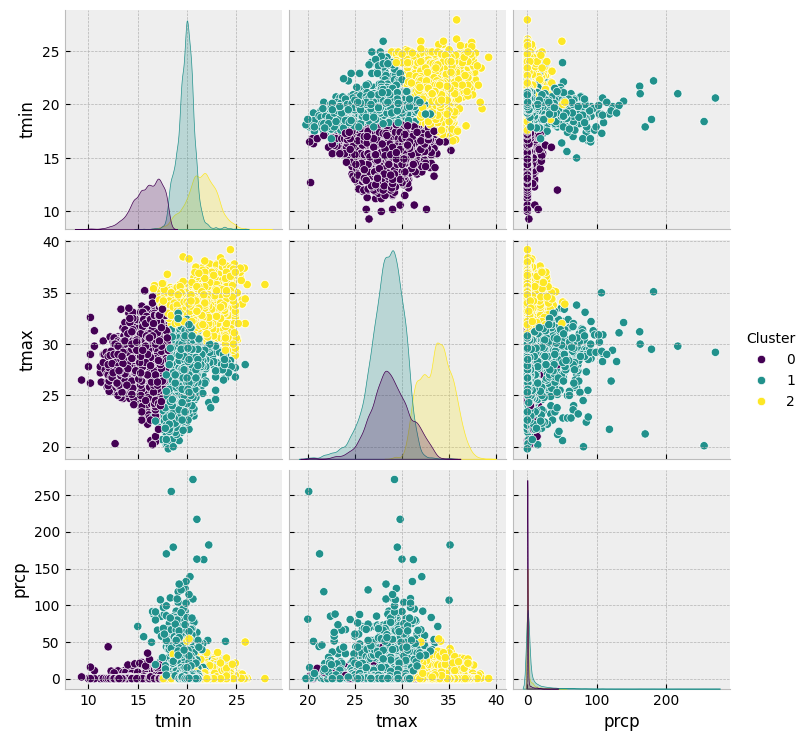

In [48]:
# Visualize in 2D using pairplot (pairwise scatterplots)
sns.pairplot(df[['tmin', 'tmax', 'prcp', 'Cluster']], hue='Cluster', palette='viridis')
plt.show()

=== Gradient Boosting Regression Model ===
Gradient Boosting Results:
Mean Absolute Error (MAE): 0.50
Mean Squared Error (MSE): 0.44
R² Score: 0.92


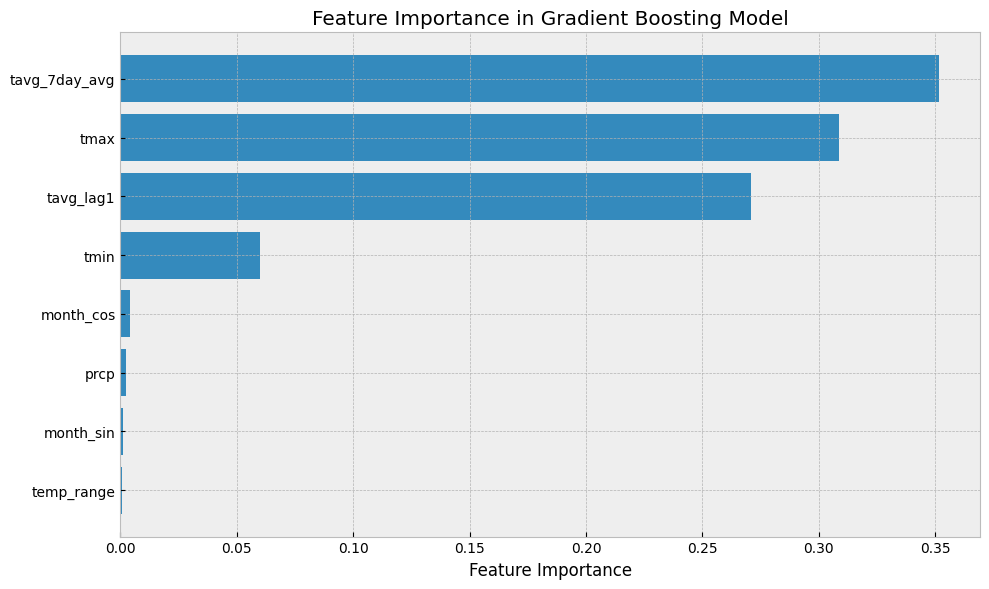

Cross-validation R² scores: [0.92212155 0.91055933 0.92648652 0.91131079 0.92423649]
Mean CV R² score: 0.92


In [53]:
#Gradient Boosting Regression
print("=== Gradient Boosting Regression Model ===")
# Prepare data for Gradient Boosting
# Use more features for this advanced model
X_gb = df[['tmin', 'tmax', 'prcp', 'temp_range', 
          'month_sin', 'month_cos', 'tavg_lag1', 'tavg_7day_avg']]
y_gb = df['tavg']
# Handle any remaining NaN values
X_gb = X_gb.fillna(0)
# Split the data
X_train_gb, X_test_gb, y_train_gb, y_test_gb = train_test_split(
    X_gb, y_gb, test_size=0.2, random_state=42)
# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# Train the model
gb_model.fit(X_train_gb, y_train_gb)
# Make predictions
y_pred_gb = gb_model.predict(X_test_gb)
# Evaluate the model
mae_gb = mean_absolute_error(y_test_gb, y_pred_gb)
mse_gb = mean_squared_error(y_test_gb, y_pred_gb)
r2_gb = r2_score(y_test_gb, y_pred_gb)
print(f"Gradient Boosting Results:")
print(f"Mean Absolute Error (MAE): {mae_gb:.2f}")
print(f"Mean Squared Error (MSE): {mse_gb:.2f}")
print(f"R² Score: {r2_gb:.2f}")
# Plot feature importances
feature_names = X_gb.columns
importances = gb_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Gradient Boosting Model')
plt.tight_layout()
plt.show()
#Cross-validation to ensure model robustness
cv_scores = cross_val_score(gb_model, X_gb, y_gb, cv=5, scoring='r2')
print(f"Cross-validation R² scores: {cv_scores}")
print(f"Mean CV R² score: {cv_scores.mean():.2f}")

In [58]:
#Time Series Forecasting with SARIMA
print("\n=== SARIMA Time Series Model ===")
# Prepare time series data
# Create a daily time series of average temperature
ts_data = df['tavg'].resample('D').mean()

# Fill any missing values that might be created by resampling
# Using ffill() instead of fillna(method='ffill') to avoid deprecation warning
ts_data = ts_data.ffill()

# Define training and testing splits for time series
train_size = int(len(ts_data) * 0.8)
train_ts, test_ts = ts_data[:train_size], ts_data[train_size:]

# Define and fit SARIMA model
# p, d, q: non-seasonal ARIMA parameters
# P, D, Q, s: seasonal ARIMA parameters (s is the seasonal period)
# Using order=(1,1,1) and seasonal_order=(1,1,1,12) for yearly seasonality
sarima_model = SARIMAX(
    train_ts,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
sarima_results = sarima_model.fit(disp=False)
print(sarima_results.summary())

# Make predictions for the test period
pred_start = len(train_ts)
pred_end = len(train_ts) + len(test_ts) - 1
sarima_preds = sarima_results.predict(start=pred_start, end=pred_end, dynamic=False)

# Evaluate the SARIMA model
mae_sarima = mean_absolute_error(test_ts, sarima_preds)
mse_sarima = mean_squared_error(test_ts, sarima_preds)
rmse_sarima = np.sqrt(mse_sarima)

print(f"SARIMA Results:")
print(f"Mean Absolute Error (MAE): {mae_sarima:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_sarima:.2f}")


=== SARIMA Time Series Model ===
                                     SARIMAX Results                                      
Dep. Variable:                               tavg   No. Observations:                 9515
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -12972.089
Date:                            Wed, 09 Apr 2025   AIC                          25954.177
Time:                                    12:30:40   BIC                          25989.966
Sample:                                01-01-1990   HQIC                         25966.323
                                     - 01-19-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5178      0.014     36.777      0.000       0.490       0.545
m

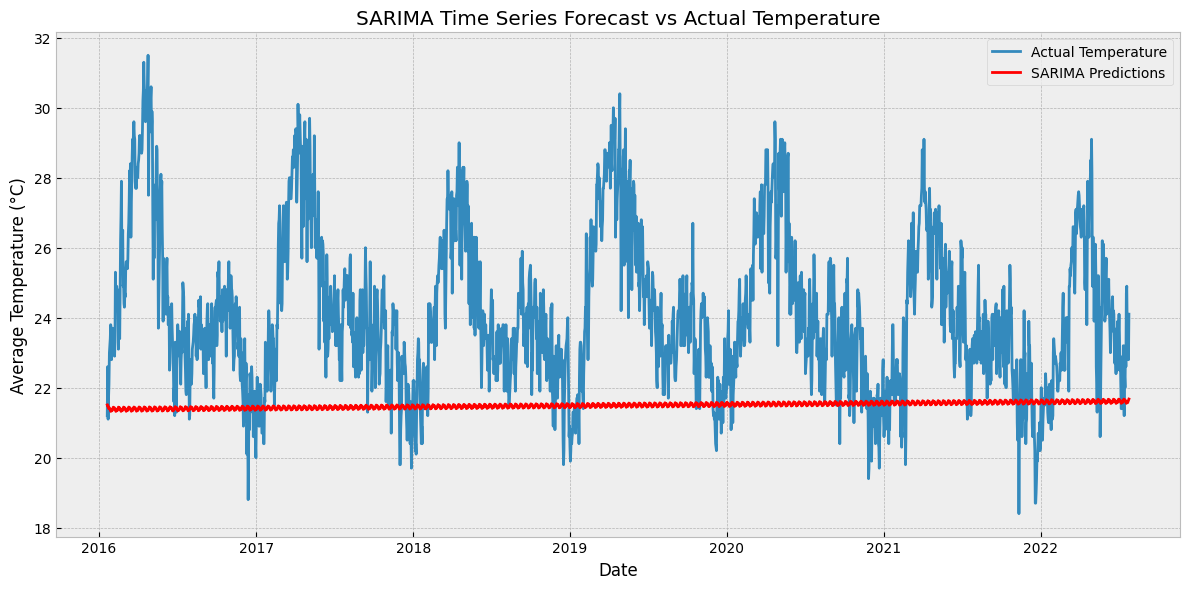

In [59]:
# Plot the predictions vs actual values
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, test_ts.values, label='Actual Temperature')
plt.plot(test_ts.index, sarima_preds, label='SARIMA Predictions', color='red')
plt.title('SARIMA Time Series Forecast vs Actual Temperature')
plt.xlabel('Date')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

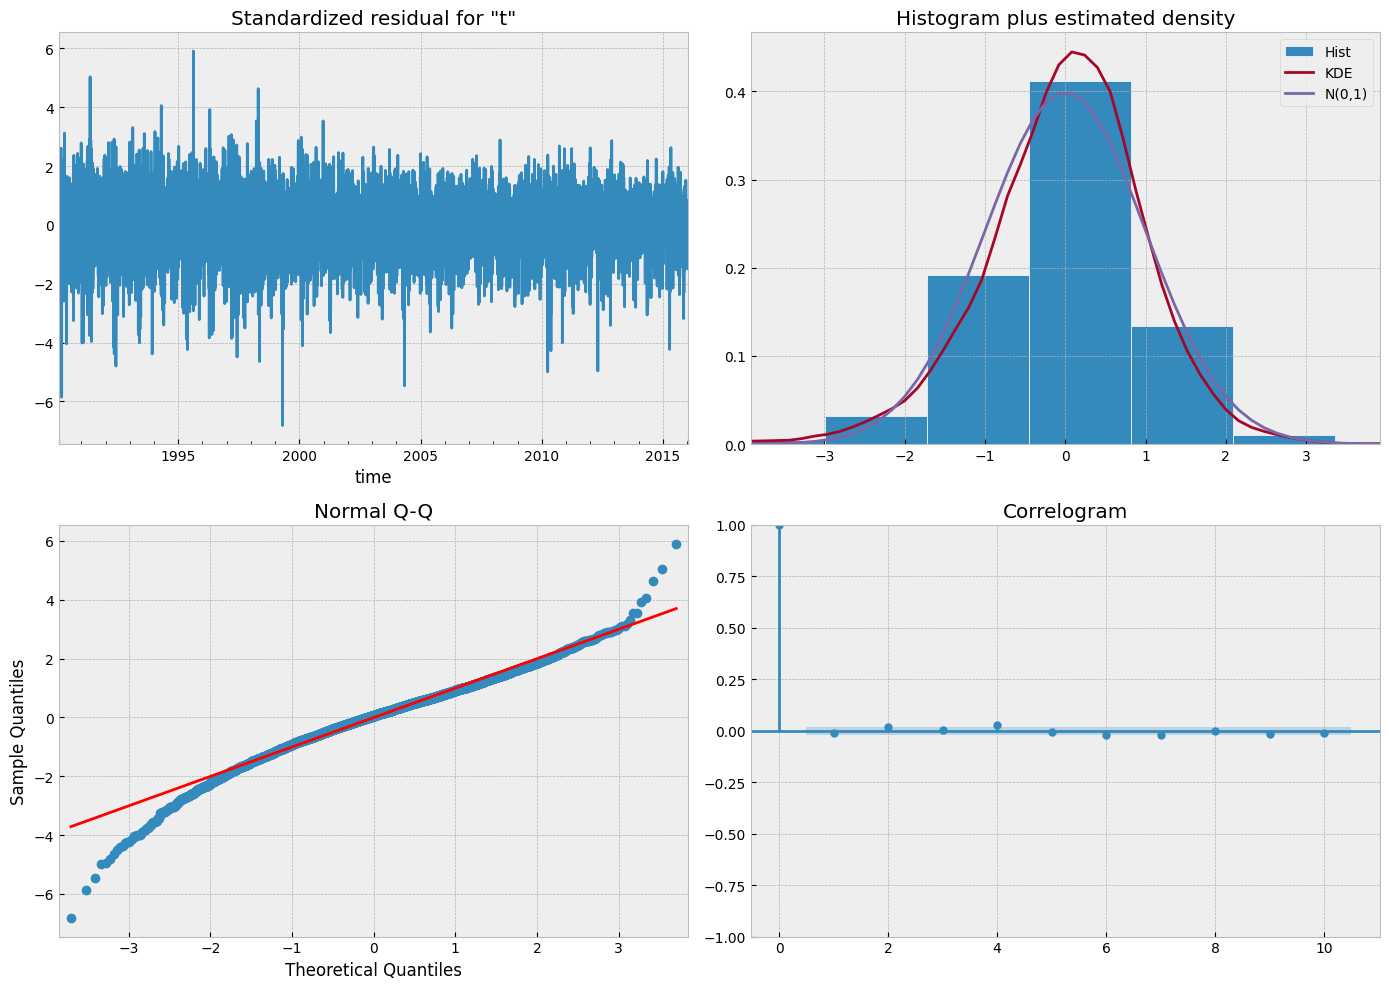

In [60]:
# Plot diagnostics to check model validity
sarima_results.plot_diagnostics(figsize=(14, 10))
plt.tight_layout()
plt.show()

In [ ]:
#Model Evaluation

In [61]:
#Basic Regression Metrics
def evaluate_basic_metrics(y_true, y_pred, model_name):
    """Calculate and display essential regression metrics"""
    # Calculate metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n=== {model_name} Evaluation ===")
    print(f"MAE: {mae:.2f} | RMSE: {rmse:.2f} | R²: {r2:.2f}")
    
    return {'mae': mae, 'rmse': rmse, 'r2': r2}

# Example: Evaluate models
rf_metrics = evaluate_basic_metrics(y_test, y_pred, "Random Forest")
gb_metrics = evaluate_basic_metrics(y_test_gb, y_pred_gb, "Gradient Boosting")


=== Random Forest Evaluation ===
MAE: 0.23 | RMSE: 0.38 | R²: 0.97

=== Gradient Boosting Evaluation ===
MAE: 0.50 | RMSE: 0.67 | R²: 0.92


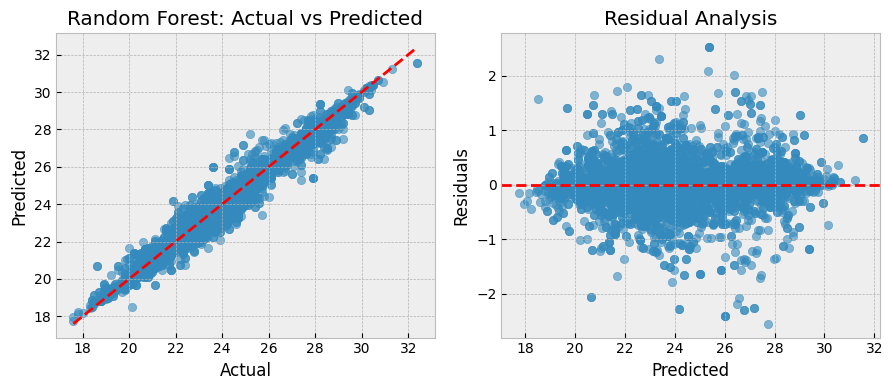

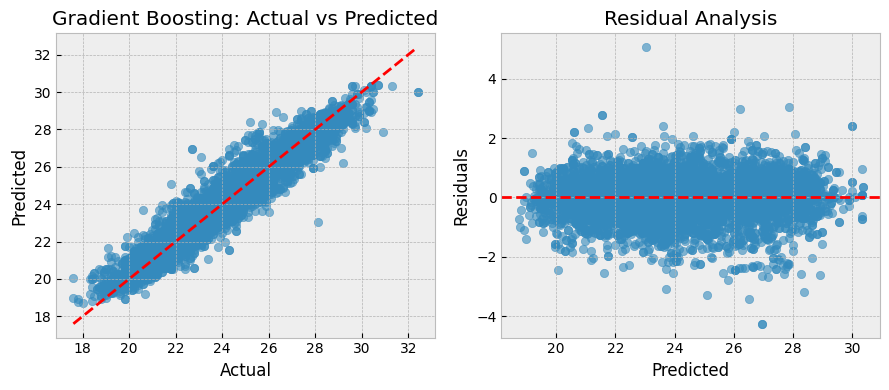

In [62]:
#Visual Evaluation - Actual vs Predicted
def plot_model_performance(y_true, y_pred, model_name):
    """Create a visual comparison of actual vs predicted values"""
    plt.figure(figsize=(9, 4))
    
    # Plot actual vs predicted values
    plt.subplot(1, 2, 1)
    plt.scatter(y_true, y_pred, alpha=0.6)
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(f'{model_name}: Actual vs Predicted')
    
    # Plot residuals
    plt.subplot(1, 2, 2)
    residuals = y_true - y_pred
    plt.scatter(y_pred, residuals, alpha=0.6)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted')
    plt.ylabel('Residuals')
    plt.title('Residual Analysis')
    
    plt.tight_layout()
    plt.show()

# Example: Plot model performance
plot_model_performance(y_test, y_pred, "Random Forest")
plot_model_performance(y_test_gb, y_pred_gb, "Gradient Boosting")


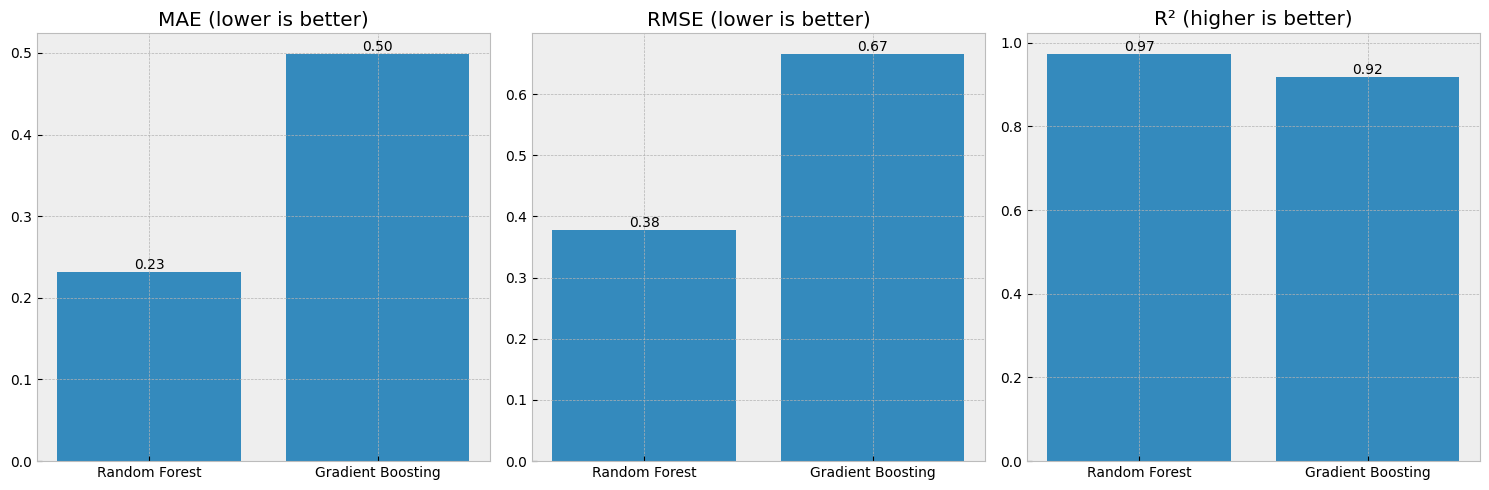

In [63]:
#Model Comparison
def compare_model_metrics(metrics_list, model_names):
    """Compare multiple models with a simple bar chart"""
    # Set up metrics to compare
    metric_keys = ['mae', 'rmse', 'r2']
    metric_labels = ['MAE (lower is better)', 'RMSE (lower is better)', 'R² (higher is better)']
    
    # Create figure with subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    for i, (metric, label) in enumerate(zip(metric_keys, metric_labels)):
        values = [m[metric] for m in metrics_list]
        axes[i].bar(model_names, values)
        axes[i].set_title(label)
        
        # Add value labels on bars
        for j, v in enumerate(values):
            axes[i].text(j, v, f'{v:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

# Example: Compare models
compare_model_metrics(
    [rf_metrics, gb_metrics], 
    ['Random Forest', 'Gradient Boosting']
)

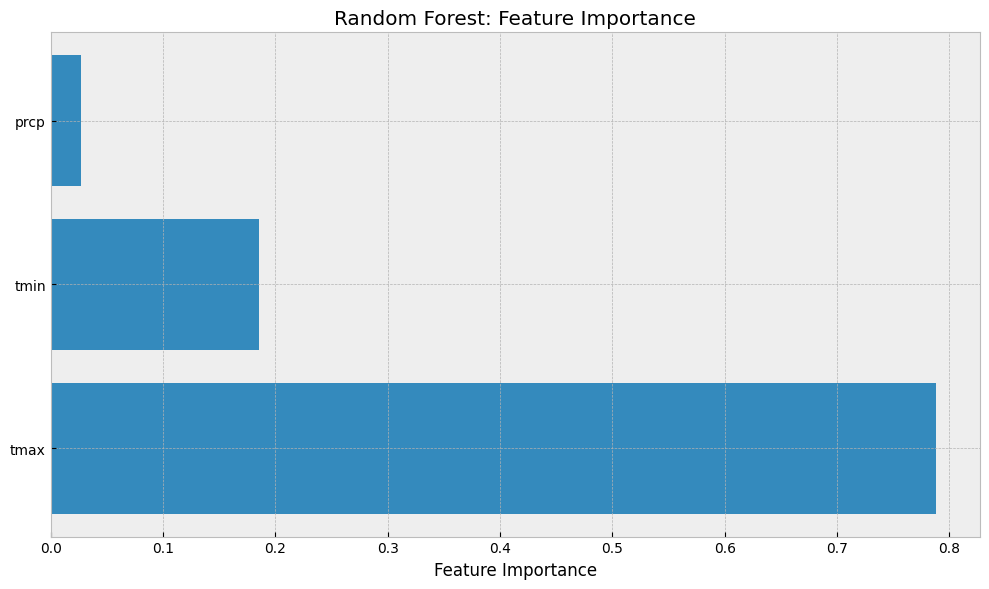


=== Random Forest Cross-Validation (R²) ===
Scores: [0.98292694 0.98062988 0.98452283 0.9809755  0.9829324 ]
Mean: 0.982 | Std: 0.001


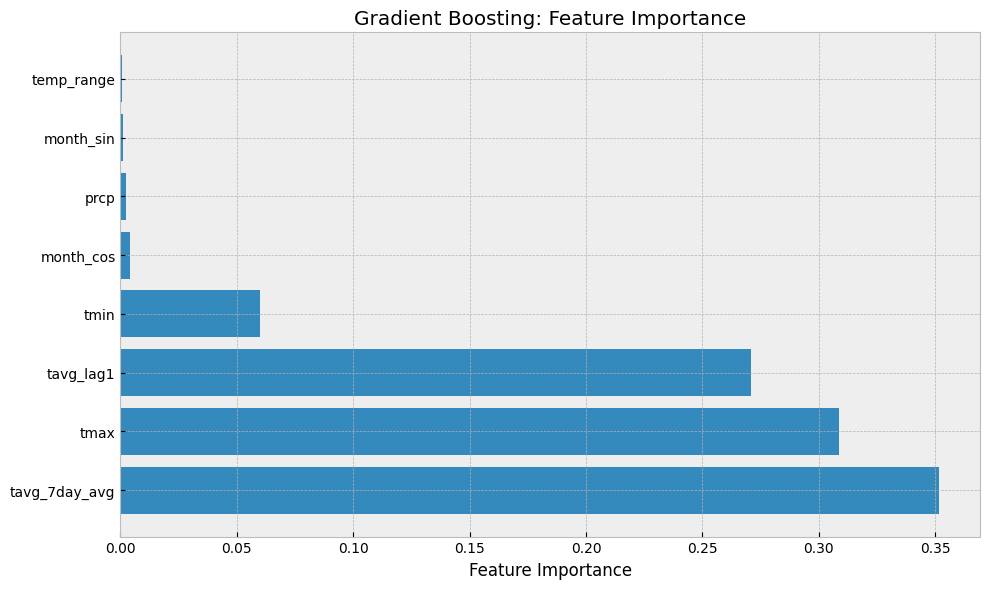


=== Gradient Boosting Cross-Validation (R²) ===
Scores: [0.92212155 0.91055933 0.92648652 0.91131079 0.92423649]
Mean: 0.919 | Std: 0.007


In [64]:
#Feature Importance and Cross-Validation
def evaluate_model_details(model, X, y, feature_names, model_name, cv=5):
    """Analyze feature importance and perform cross-validation"""
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    
    # Get and sort feature importances
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    # Plot feature importance bars
    plt.barh(range(len(indices)), importances[indices], align='center')
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance')
    plt.title(f'{model_name}: Feature Importance')
    
    plt.tight_layout()
    plt.show()
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
    print(f"\n=== {model_name} Cross-Validation (R²) ===")
    print(f"Scores: {cv_scores}")
    print(f"Mean: {cv_scores.mean():.3f} | Std: {cv_scores.std():.3f}")

# Example: Evaluate model details
evaluate_model_details(model, X, y, X.columns, "Random Forest")
evaluate_model_details(gb_model, X_gb, y_gb, X_gb.columns, "Gradient Boosting")